# Getting started with image classification

In this tutorial, we will download a pre-trained image classifier from the ELL Gallery. First, we will choose a model and try it out on Azure, to see it classify images. Then we can download the notebook to Jupyter running on your laptop or desktop machine. Running the notebook on your local machine allows the notebook to connect directly to your Raspberry Pi over your local network.

![screenshot](https://microsoft.github.io/ELL/tutorials/Getting-Started-with-Image-Classification-on-the-Raspberry-Pi/Screenshot.png)

Our first step is to install the `ell` package.

In [1]:
!conda config --prepend channels conda-forge --prepend channels microsoft-ell
!conda install -y ell

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_431:

The following NEW packages will be INSTALLED:

    bcrypt:    3.1.3-py36_0                      
    ell:       0.0.1-py36h0a24ad1_0 microsoft-ell
    llvmdev:   3.9.1-h5745f8f_0     microsoft-ell
    paramiko:  2.2.1-py36_0         conda-forge  
    pynacl:    1.1.2-py36_0         conda-forge  
    swig:      3.0.12-2             conda-forge  
    system:    5.8-2                             

The following packages will be UPDATED:

    conda:     4.3.25-py36_0                      --> 4.3.27-py36_0 conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    conda-env: 2.6.0-0                            --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.01 MB/s
system-5.8-2.t 100% |################################| Time: 0:00:00   3.74 MB/s
llvmdev-3.9.1

## Download a pre-trained model

The [ELL Gallery](https://microsoft.github.io/ELL/gallery) contains a number of pretrained Deep Neural Networks for image classification. These models vary in the size of the image input that they accept and their network architectures. To get started, instantiate the ModelGallery class, which allows us to choose one of the available models. If you are unfamiliar with these networks, feel free to stick with the default choice.

In [2]:
from ell.util.gallery import ModelGallery
gallery = ModelGallery()
gallery.choose_model()

Based on the selections above, the `gallery` object has a field `model` with our choice of model. Download this model to the Azure Notebook. The `download` method has parameters to name a local directory in which to download the model. By default, a model has a complicated name that reflects its architecture. The optional `rename` parameter gives the model a simpler name.

In [ ]:
pretrained_model = gallery.model
pretrained_model.download('getting-started', rename='model')

'getting-started/model.ell.zip'

## Compile the model for our Azure Notebook

ELL models can be built for a variety of platforms, including cloud virtual machines, laptops, desktops and microcontrollers. After downloading the model, build it to run our Azure virtual machine. This creates a subdirectory `host` containing a CMake project that compiles the model to a native library. The project also creates a Python module for this native library, so we can work with the model in the notebook.

In [ ]:
pretrained_model.build()

compiling...
-- Generating done
-- Build files have been written to: /home/nbuser/library/getting-started/host
[100%] Built target _model


## Run the model in Azure

Use the `load` method to import the model's Python module. Print the model’s input and output shapes.

In [ ]:
model = pretrained_model.load()

In [ ]:
input_shape = model.get_default_input_shape()
output_shape = model.get_default_output_shape()
print("Model input shape: " + str([input_shape.rows,input_shape.columns,input_shape.channels]))
print("Model output shape: " + str([output_shape.rows,output_shape.columns,output_shape.channels]))

Model input shape: [160, 160, 3]
Model output shape: [1, 1, 1000]


The input to the model is a 3-channel image of height 160 and width 160 (which can also be represented as an array of size 160 \* 160 \* 3 = 76,800). The shape of the output is 1 x 1 x 1000, which can be represented as an array of 1000 elements. Allocate an array to store the model’s output.

In [ ]:
predictions = model.FloatVector(output_shape.Size())

Choose an image file to send to the model. For example, use our coffee mug image, [coffeemug.jpg](https://microsoft.github.io/ELL/tutorials/shared/coffeemug.jpg). Use OpenCV to read the image:

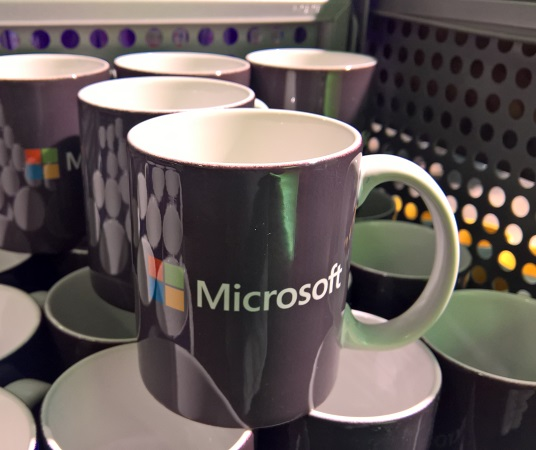

In [ ]:
import urllib.request
import cv2
import numpy as np
urllib.request.urlretrieve('https://microsoft.github.io/ELL/tutorials/shared/coffeemug.jpg', 'getting-started/coffeemug.jpg')
image = cv2.imread("getting-started/coffeemug.jpg")
from IPython.display import Image
display(Image('getting-started/coffeemug.jpg'))

The image stored in the `image` variable cannot be sent to the model as-is, because the model takes its input as an array of float values. Moreover, the model expects the input image to have a certain shape and a specific ordering of the color channels (which, in this case, is Blue-Green-Red). Since preparing images for the model is such a common operation, we created a helper function for it called `prepare_image`.

In [ ]:
input = pretrained_model.prepare_image(image)

Finally, invoke the model by calling its `predict` method.

In [ ]:
model.predict(input, predictions)

The `predict` method fills the `predictions` array with probability scores, which sum to 1. Each element of this array corresponds to one of the 1000 image classes recognized by the model. Print the index of the highest confidence category. This code also looks up the category name by reading the corresponding line in `categories.txt`. For example, if the highest confidence category is 504, line 504 of `categories.txt` is `coffee mug`. The value at `predictions[504]` is the model's confidence in this prediction. For example, a value of `0.514353` means that the model is 51% confident that the image contains a coffee mug.

In [12]:
categories = [line.strip('\n') for line in open('getting-started/categories.txt', 'r').readlines()]
predictionIndex = int(np.argmax(predictions))
print("Category: " + categories[predictionIndex])
print("Confidence: " + str(predictions[predictionIndex]))

Category: coffee mug
Confidence: 0.8283082246780396


The model successfully identified the image as a coffee mug with 83% confidence. Feel free to download other images and try the model on them.